In [1]:
# author: Zhuo Shen

In [2]:
import torch
print("Using torch", torch.__version__)
import numpy as np
import os
import time
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.autograd import grad
import torch.utils.data as data

import matplotlib.pyplot as plt

%matplotlib inline

Pi = np.pi

Using torch 2.0.1


In [3]:
dev = torch.device("cpu")

In [4]:
# if torch.backends.mps.is_available():
#     dev = torch.device("mps")
#     mps_device = torch.device("mps")
# else:
#     dev = torch.device("cpu")
#     print ("MPS device not found. Use CPU instead")

In [5]:
#a very simple torch method to compute derivatives.
def nth_derivative(f, wrt, n):
    for i in range(n):
        grads = grad(f, wrt, create_graph=True, allow_unused=True)[0]
        f = grads.sum()
        if grads is None:
            print('bad grad')
            return torch.tensor(0.)
    return grads

In [6]:
# This class is a general Neural Network (fully connected, feed forward neural network), a.k.a Multi Layer Perceptron (MLP)
# Our PINN will be represented by a neural network of this type
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.il  = nn.Linear(3,20)   
        self.hl1  = nn.Linear(20,200) 
        self.hl2 = nn.Linear(200,200)  
        self.hl3 = nn.Linear(200,200)  
        self.hl4 = nn.Linear(200,200)  
        self.hl5 = nn.Linear(200,20) 
        self.ol  = nn.Linear(20,1)   
        
        self.tn  = nn.Tanh()

    def forward(self, x, y, t):
        u = torch.cat((x, y, t), 1)
        u = self.il(u)
        u = self.hl1(self.tn(u))
        u = self.hl2(self.tn(u))
        u = self.hl3(self.tn(u))
        u = self.hl4(self.tn(u))
        u = self.hl5(self.tn(u))
        u = self.ol(u)
        return u

In [7]:
# Parameters
nu = 0.1

def diffusion_2D(x,y,t,model):    
    u = model(x,y,t)
    u_t = nth_derivative(u.sum(), t, 1)
    u_xx = nth_derivative(u.sum(), x, 2)
    u_yy = nth_derivative(u.sum(), y, 2)
    
    f = -u_t + nu*u_xx + nu*u_yy
    return f

In [8]:
class BC_Data(data.Dataset):
    def __init__(self, nx, ny, nt):
        """
        Inputs:
            nx - number of points used to sample boundary conditions in x
            ny - number of points used to sample boundary conditions in y
            nt - number of points used to sample boundary conditions in t
        """
        super().__init__()
        self.nx = nx
        self.ny = ny
        self.nt = nt
        self.generate_bc_data()

    def generate_bc_data(self):
        # u(x,y,t=0) = -1 for y not equal to 1
        # u(x,1,t=0) = 1
        x = np.linspace(0, 1, self.nx)
        y = np.linspace(0, 1, self.ny)
        t = np.linspace(0, 1, self.nt)
        u = -np.ones((self.ny, self.nx))
        u[-1] = 1
        
        X,Y = np.meshgrid(x,y)
        x_bc = torch.from_numpy(X.reshape(-1)).float()
        y_bc = torch.from_numpy(Y.reshape(-1)).float()
        t_bc = torch.from_numpy(np.zeros(self.nx*self.ny)).float()
        u_bc = torch.from_numpy(u.reshape(-1)).float()
        
        # u(x, y=0,t) = -1
        X,T = np.meshgrid(x,t)
        x_bc = torch.cat((x_bc, torch.from_numpy(X.reshape(-1)).float()))
        y_bc = torch.cat((y_bc, torch.from_numpy(np.zeros(self.nx*self.nt)).float()))
        t_bc = torch.cat((t_bc, torch.from_numpy(T.reshape(-1)).float()))
        u_bc = torch.cat((u_bc, torch.from_numpy(-np.ones(self.nx*self.nt)).float()))

        # u(x, y=1,t) = 1
        x_bc = torch.cat((x_bc, torch.from_numpy(X.reshape(-1)).float()))
        y_bc = torch.cat((y_bc, torch.from_numpy(np.ones(self.nx*self.nt)).float()))
        t_bc = torch.cat((t_bc, torch.from_numpy(T.reshape(-1)).float()))
        u_bc = torch.cat((u_bc, torch.from_numpy(np.ones(self.nx*self.nt)).float()))
        
        # u(x=0, y,t) = -1
        Y,T = np.meshgrid(y,t)
        x_bc = torch.cat((x_bc, torch.from_numpy(np.zeros(self.ny*self.nt)).float()))
        y_bc = torch.cat((y_bc, torch.from_numpy(Y.reshape(-1)).float()))
        t_bc = torch.cat((t_bc, torch.from_numpy(T.reshape(-1)).float()))
        u_bc = torch.cat((u_bc, torch.from_numpy(-np.ones(self.ny*self.nt)).float()))
        
        # u(x=1, y,t) = -1
        Y,T = np.meshgrid(x,t)
        x_bc = torch.cat((x_bc, torch.from_numpy(np.ones(self.ny*self.nt)).float())).reshape(-1,1)
        y_bc = torch.cat((y_bc, torch.from_numpy(Y.reshape(-1)).float())).reshape(-1,1)
        t_bc = torch.cat((t_bc, torch.from_numpy(T.reshape(-1)).float())).reshape(-1,1)
        u_bc = torch.cat((u_bc, torch.from_numpy(-np.ones(self.ny*self.nt)).float())).reshape(-1,1)
    
        x_bc.requires_grad = True
        y_bc.requires_grad = True
        t_bc.requires_grad = True
        u_bc.requires_grad = False

        self.x = x_bc.to(dev)
        self.y = y_bc.to(dev)
        self.t = t_bc.to(dev)
        self.u = u_bc.to(dev)

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.u.shape[0]

    
class RandCollocationPoints(data.Dataset):

    def __init__(self, n_coll_pts):
        """
        Inputs:
            n_coll_pts - Number of randomly selected collocation points
        """
        super().__init__()
        self.n_coll_pts = n_coll_pts
        self.generate_coll_points()

    def generate_coll_points(self):
    
        x = np.random.uniform(0,1, self.n_coll_pts) # uniform random sampling of x between 0 and 1
        y = np.random.uniform(0,1, self.n_coll_pts) # uniform random sampling of y between 0 and 1
        t = np.random.uniform(0,1, self.n_coll_pts) # uniform random sampling of t between 0 and 1
        
        x = torch.from_numpy(x).float().reshape(-1,1)
        y = torch.from_numpy(y).float().reshape(-1,1)
        t = torch.from_numpy(t).float().reshape(-1,1)
        
        x.requires_grad = True
        y.requires_grad = True
        t.requires_grad = True
        
        self.x = x.to(dev)
        self.y = y.to(dev)
        self.t = t.to(dev)

In [9]:
# Setting random seeds so that the results can be exactly reproduced
np.random.seed(88)
torch.random.manual_seed(88)

# Create Boundary condition data (object of the BC_Data class)
bc_data = BC_Data(nx = 40, ny = 40, nt = 20)

In [10]:
# Initialize nn_model
pinn = MLP().to(dev)

# Create empty lists to track optimization progress of the boundary conditions (L_bc) + optimization of PDE (L_pde)
L_bc_evol = []
L_pde_evol = []

# Initialize optimizer -- Setting pinn parameters as the parameters to be optimized. Starting with a learning rate lr = 0.001 (good rule of thumb)
optimizer = optim.Adam(pinn.parameters(), lr=0.0005)
criterion = torch.nn.MSELoss()

num_epochs = 10001 # This sets the number of optimization iterations 

for epoch in range(num_epochs):
    ###################################################################
    # Evaluate discrepancy relative to the boundary conditions (L_bc)
    ###################################################################
    pinn_at_bc_pts = pinn(bc_data.x, bc_data.y, bc_data.t) # evaluating pinn at boundary
    L_bc = criterion(pinn_at_bc_pts, bc_data.u) # computing mean squared error between pinn and boundary condition values
    ###################################################################

    
    ###################################################################
    # Evaluate discrepancy relative to the PDE (L_PDE)
    ###################################################################
    coll_pts = RandCollocationPoints(n_coll_pts = 800) # randomly select n_coll_pts = 800 in the domain 
    pinn_at_coll_pts = diffusion_2D(torch.cat((bc_data.x,coll_pts.x)), torch.cat((bc_data.y,coll_pts.y)), torch.cat((bc_data.t,coll_pts.t)), pinn) # evaluate PDE residual at collocation points

    L_pde = criterion(pinn_at_coll_pts, torch.zeros(pinn_at_coll_pts.shape).to(dev)) # computing mean squared error of the PDE residuals
    ###################################################################
    
    
    ###################################################################
    # Optimize PINN parameters
    ###################################################################
    L_bc_pde = L_bc + L_pde # Combine the boundary condition and PDE residuals
    
    # Now we optimize (always done by these 3 steps):
    optimizer.zero_grad() # set all gradients previously calculated to zero
    L_bc_pde.backward() # compute gradient of our objective function (that we want to minimize) with respect to the parameters of the PINN
    optimizer.step() # update the parameters of the PINN according to gradient descent
    ###################################################################
    
    # Append L_bc and L_pde values to track their evolution
    L_bc_evol.append(L_bc.item())
    L_pde_evol.append(L_pde.item())
    
    if (epoch % 500 == 0) or (epoch == num_epochs-1):
        print('epoc = ', epoch)
        print('loss = ', float(L_bc_pde))
#     if epoch % 5000 == 0 and epoch != 0: # uncomment this line to save model
#         torch.save(pinn.state_dict(), 'diffusion_2D.pt') # uncomment this line to save model
        

epoc =  0
loss =  0.9321688413619995


KeyboardInterrupt: 

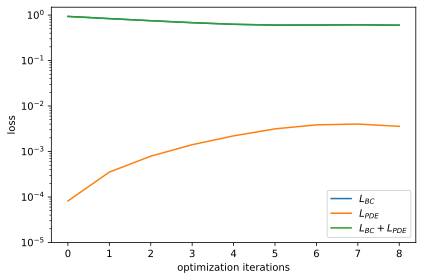

In [11]:
plt.semilogy(L_bc_evol, label = r'$L_{BC}$')
plt.semilogy(L_pde_evol, label = r'$L_{PDE}$')
plt.semilogy(np.array(L_bc_evol) + np.array(L_pde_evol), label = r'$L_{BC}+L_{PDE}$')
plt.ylabel('loss')
plt.xlabel('optimization iterations')
plt.ylim(1e-5,)
plt.legend()
plt.tight_layout()

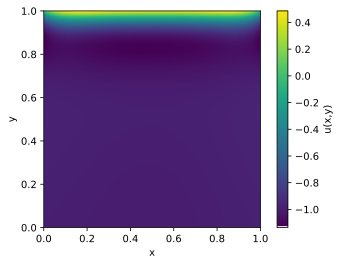

In [12]:
# Use trained model
model = MLP()
model.load_state_dict(torch.load('diffusion_2D.pt', map_location=torch.device('cpu')))
model.eval() # since we need to use the model for inference

vxn = 80
vyn = 80
vtn = 40
vx = np.linspace (0, 1, vxn)
vy = np.linspace (0, 1, vyn)
vt = np.linspace (0, 1, vtn)
Vx, Vy = np.meshgrid(vx,vy)
Vx = torch.FloatTensor(Vx.flatten().reshape(-1,1))
Vy = torch.FloatTensor(Vy.flatten().reshape(-1,1))
Vt = (0*torch.from_numpy(np.ones(vxn*vyn))).reshape(-1,1).float()

u_test = model(Vx, Vy, Vt).reshape(vxn,vyn)
u_test = u_test.detach().numpy()

plt.imshow(u_test, origin = 'lower', extent = [0,1,0,1], aspect='equal')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label = 'u(x,y)')
plt.show()

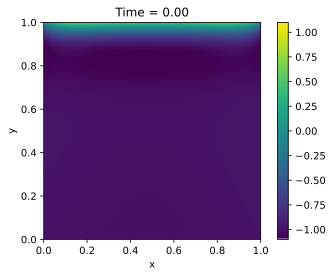

In [13]:
from matplotlib.animation import FuncAnimation
from IPython import display

fig = plt.figure()
ax = fig.add_subplot(111)

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 300

Vt = (0*torch.from_numpy(np.ones(vxn*vyn))).reshape(-1,1).float()
u_test = model(Vx, Vy, Vt).reshape(vxn,vyn)
u_test = u_test.detach().numpy()

im = ax.imshow(u_test, origin = 'lower', extent = [0,1,0,1], aspect='equal', vmin=-1.1, vmax=1.1)
cb = fig.colorbar(im)

def animate(t):
    Vt = (vt[t]*torch.from_numpy(np.ones(vxn*vyn))).reshape(-1,1).float()
    u_test = model(Vx, Vy, Vt).reshape(vxn,vyn)
    u_test = u_test.detach().numpy()
    plt.cla()
    plt.imshow(u_test, origin = 'lower', extent = [0,1,0,1], aspect='equal', vmin=-1.1, vmax=1.1)
    plt.title(f'Time = {vt[t]:0.2f}')
    plt.xlabel('x')
    plt.ylabel('y')

anim = FuncAnimation(fig, animate, frames=vtn, interval = 100)
anim
# anim.save('2D_diffusion.gif', fps=10)